# Intro to  Neural Networks with PyTorch
## Task 2 – CIFAR-10 Baselines

**Objective:** To classify images with 1 of 10 class labels.

**Dataset + Split:** CIFAR-10 from torchvision (60,000 color images (32×32)). 50,000 images for training set with exactly 5000 per class, 10,000 for test set with exactly 1000 per class.

**Models Used:** MLP and CNN

### Import and Preprocess Dataset

In [51]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split 

# Compute mean and standard deviation of dataset for nomalization
dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)

loader = DataLoader(dataset, batch_size=50000) # Entire training dataset
images, _ = next(iter(loader)) # images, _ => (images, labels)

mean = images.mean(dim=[0, 2, 3]) # Ignore dimension 1 so that mean and std are computed separately for each channel
std = images.std(dim=[0, 2, 3])
print(f"Mean: {mean}, Std: {std}")

# Transforms (To convert images to tensors and normalize them)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

Mean: tensor([0.4914, 0.4822, 0.4465]), Std: tensor([0.2470, 0.2435, 0.2616])


In [52]:
# Load training and test sets with transforms
train_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Split into train/val (45k, 5k)
val_size = 5000
train_size = len(train_full) - val_size
train_set, val_set = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(40))

print(f"Train/Val/Test Shape: {len(train_set)}, {len(val_set)}, {len(test_set)}")

Train/Val/Test Shape: 45000, 5000, 10000


In [53]:
# Define dataloaders
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

xb, yb = next(iter(train_loader))
print(f"Train batch sizes: Image batch=>{xb.shape}, Label batch=>{yb.shape}")
print(f"Label datatype: {yb.dtype}")

Train batch sizes: Image batch=>torch.Size([128, 3, 32, 32]), Label batch=>torch.Size([128])
Label datatype: torch.int64


In [54]:
# Check class names
class_names = train_full.classes # Used in confusion matrix later
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### MLP Implementation

In [56]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    # DEFINE NETWORK
    def __init__(self, in_dim=3*32*32, width=256, depth=2, dropout=0.2, num_classes=10):
        super().__init__() # Initialization of parent module
        
        layers = []
        d = in_dim # Incoming input size for each layer
        for _ in range(depth):
            layers += [nn.Linear(d, width), nn.ReLU()] # Connects 'd' inputs to 'width' neurons and applies activation function 
            if dropout and dropout > 0: # Applies dropout
                layers += [nn.Dropout(dropout)]
            d = width # Updates input size
        layers += [nn.Linear(d, num_classes)] # Final output layer (10 logits)
        self.net = nn.Sequential(*layers) # Combines all layers into one block and unpacks the list

    # DEFINE FLOW THROUGH NETWORK
    def forward(self, x): # Moves input through layers of self.net(x)
        # x is [B, 3, 32, 32] from CIFAR-10 loaders
        x = x.view(x.size(0), -1) # Flatten -> [B, 3072]
        logits = self.net(x) # [B, 10]
        return logits

In [57]:
# Loss, Optimizer, Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(width=256, depth=2, dropout=0.1).to(device) # Create model using device
criterion = nn.CrossEntropyLoss() # Cross entropy loss (Applies softmax function internally and calculates NLLLoss -> Negative Log-Likelihood Loss)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) # Method of optimization of weights during gradient descent

In [58]:
# Define evaluator for ACC
def evaluate(loader, model, criterion, device):
    model.eval() # Switches model to evaluation mode => Dropout is disabled, BatchNorm uses stored statistics
    # Initialize variables
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_preds = [] # For confusion matrix
    all_labels = []

    with torch.no_grad(): # Turns off gradient tracking since no backpropagation is used
        for xb, yb in loader: 
            xb, yb = xb.to(device), yb.to(device) # Move tensors to same device
            logits = model(xb) # Forward pass to get logits
            loss = criterion(logits, yb) # Calculate CrossEntropyLoss
            preds = torch.argmax(logits, dim=1) # Find maximum value of logit => Predicted class (Shape: [B])

            all_preds.append(preds.cpu()) # For confusion matrix
            all_labels.append(yb.cpu())

            total_loss += loss.item() * xb.size(0) # Batch loss
            total_correct += (preds == yb).sum().item()
            total_samples += xb.size(0) 

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    avg_loss = total_loss / total_samples # Average loss per sample this epoch
    avg_acc = total_correct / total_samples # Average accuracy
    return avg_loss, avg_acc, all_preds, all_labels

#### - Training, Validation, Testing

In [60]:
# Train and validate
import copy

best_state = None
best_val_acc = -1.0

# For plotting
train_loss_hist = []
train_acc_hist  = []
val_loss_hist   = []
val_acc_hist    = []

max_epochs = 10
for epoch in range(1, max_epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # TRAINING
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True) # Reset gradients from previous step
        
        logits = model(xb) # Forward pass              
        loss = criterion(logits, yb) # Compute CrossEntropy Loss
        loss.backward() # Backpropagate to compute gradients of loss w.r.t. every trainable parameter
        optimizer.step() # Update weights using AdamW

        running_loss += loss.item() * xb.size(0) # Update batch loss
        preds = logits.argmax(dim=1) # Find predictions
        running_correct += (preds == yb).sum().item() # Correct predictions
        running_total += xb.size(0) # Total samples

    train_loss = running_loss / running_total 
    train_acc  = running_correct / running_total

    # VALIDATION
    val_loss, val_acc, _, _ = evaluate(val_loader, model, criterion, device)

    # For plotting
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    # Checkpoint if val accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = copy.deepcopy(model.state_dict()) # Save best weights

    print(f"Epoch {epoch:02d} | "
          f"train_loss={train_loss:.4f} | train_acc={train_acc:.3f} | "
          f"val_loss={val_loss:.4f} | val_acc={val_acc:.3f}")

# After training, load best model
if best_state is not None:
    model.load_state_dict(best_state)

# TESTING
test_loss, test_acc, all_preds, all_labels = evaluate(test_loader, model, criterion, device)
print("\nFinal Evaluation:")
print(f"Best Val Acc={best_val_acc:.3f} | Test Acc={test_acc:.3f} | Test Loss={test_loss:.4f}")

Epoch 01 | train_loss=1.6918 | train_acc=0.401 | val_loss=1.5386 | val_acc=0.443
Epoch 02 | train_loss=1.4996 | train_acc=0.469 | val_loss=1.4796 | val_acc=0.477
Epoch 03 | train_loss=1.4073 | train_acc=0.503 | val_loss=1.4376 | val_acc=0.485
Epoch 04 | train_loss=1.3345 | train_acc=0.529 | val_loss=1.4032 | val_acc=0.502
Epoch 05 | train_loss=1.2822 | train_acc=0.548 | val_loss=1.3917 | val_acc=0.513
Epoch 06 | train_loss=1.2337 | train_acc=0.564 | val_loss=1.3849 | val_acc=0.512
Epoch 07 | train_loss=1.1741 | train_acc=0.583 | val_loss=1.3807 | val_acc=0.530
Epoch 08 | train_loss=1.1380 | train_acc=0.597 | val_loss=1.3729 | val_acc=0.530
Epoch 09 | train_loss=1.0987 | train_acc=0.609 | val_loss=1.3957 | val_acc=0.525
Epoch 10 | train_loss=1.0632 | train_acc=0.621 | val_loss=1.4121 | val_acc=0.519

Final Evaluation:
Best Val Acc=0.530 | Test Acc=0.532 | Test Loss=1.3603


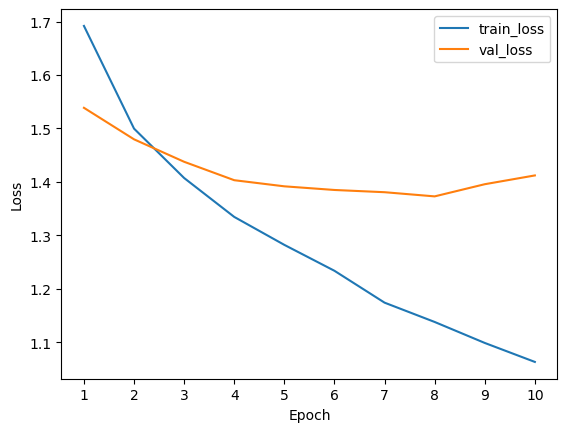

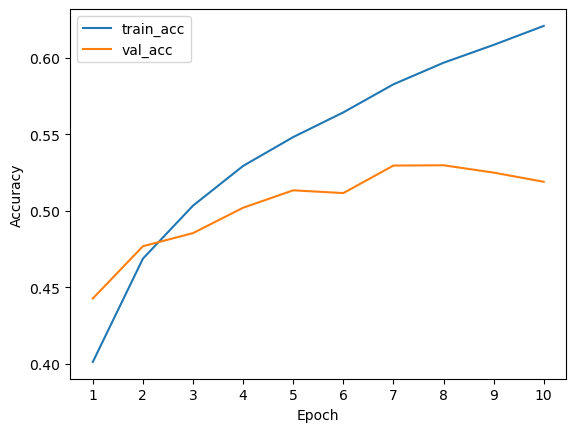

In [61]:
# Plotting loss and accuracy
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_hist) + 1)

plt.figure()
plt.plot(epochs, train_loss_hist, label="train_loss")
plt.plot(epochs, val_loss_hist, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_acc_hist, label="train_acc")
plt.plot(epochs, val_acc_hist, label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()
plt.show()

(10, 10)


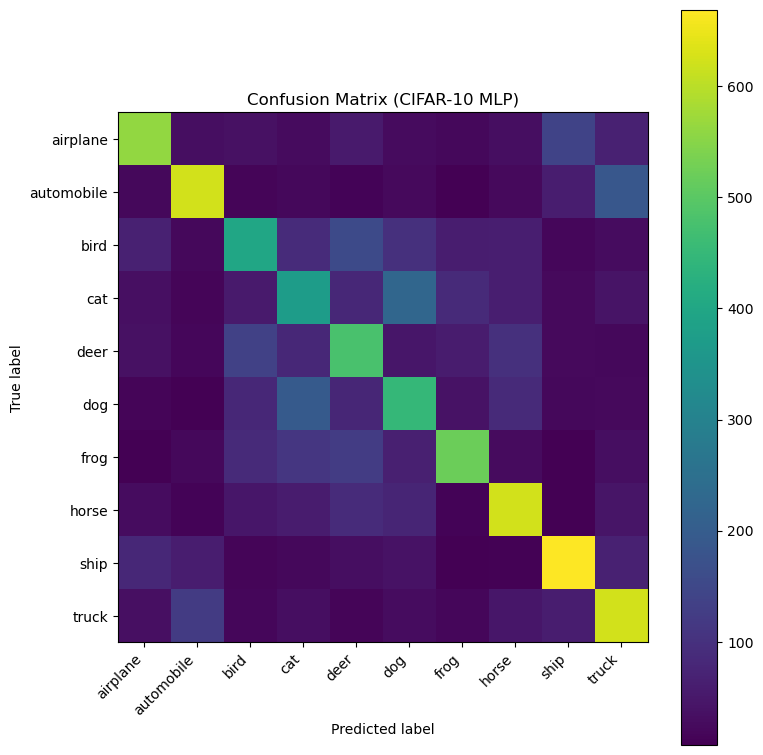

In [62]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape) 

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (CIFAR-10 MLP)")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.tight_layout()
plt.show()

### CNN

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    # DEFINE NETWORK
    def __init__(self, num_classes=10, dropout=0.3):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # [B,32,32,32]; 32 filters are learned, each representing a different local pattern
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # [B,32,32,32]
            nn.ReLU(),
            nn.MaxPool2d(2), # [B,32,16,16], because 2x2 window for pooling

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B,64,16,16]
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # [B,64,16,16]
            nn.ReLU(),
            nn.MaxPool2d(2), # [B,64,8,8]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), # [B, 64*8*8] => [B,4096]
            nn.Linear(in_features= 64 * 8 * 8, out_features=256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes) # logits: [B,10]
        )

    # DEFINE FLOW THROUGH NETWORK
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [65]:
# Loss, Optimizer, Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [66]:
# Using same evaluator function as before

#### - Training, Testing, Validation

In [68]:
# Train and validate
import copy

best_state = None
best_val_acc = -1.0

# For plotting
train_loss_hist = []
train_acc_hist  = []
val_loss_hist   = []
val_acc_hist    = []

max_epochs = 10
for epoch in range(1, max_epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # TRAINING
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True) # Reset gradients from previous step
        
        logits = model(xb) # Forward pass              
        loss = criterion(logits, yb) # Compute CrossEntropy Loss
        loss.backward() # Backpropagate to compute gradients of loss w.r.t. every trainable parameter
        optimizer.step() # Update weights using AdamW

        running_loss += loss.item() * xb.size(0) # Update batch loss
        preds = logits.argmax(dim=1) # Find predictions
        running_correct += (preds == yb).sum().item() # Correct predictions
        running_total += xb.size(0) # Total samples

    train_loss = running_loss / running_total 
    train_acc  = running_correct / running_total

    # VALIDATION
    val_loss, val_acc, _, _ = evaluate(val_loader, model, criterion, device)

    # For plotting
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    # Checkpoint if val accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = copy.deepcopy(model.state_dict()) # Save best weights

    print(f"Epoch {epoch:02d} | "
          f"train_loss={train_loss:.4f} | train_acc={train_acc:.3f} | "
          f"val_loss={val_loss:.4f} | val_acc={val_acc:.3f}")

# After training, load best model
if best_state is not None:
    model.load_state_dict(best_state)

# TESTING
test_loss, test_acc, all_preds, all_labels = evaluate(test_loader, model, criterion, device)
print("\nFinal Evaluation:")
print(f"Best Val Acc={best_val_acc:.3f} | Test Acc={test_acc:.3f} | Test Loss={test_loss:.4f}")

Epoch 01 | train_loss=1.5270 | train_acc=0.443 | val_loss=1.1915 | val_acc=0.563
Epoch 02 | train_loss=1.0507 | train_acc=0.627 | val_loss=0.9522 | val_acc=0.660
Epoch 03 | train_loss=0.8384 | train_acc=0.705 | val_loss=0.8169 | val_acc=0.710
Epoch 04 | train_loss=0.7089 | train_acc=0.747 | val_loss=0.7693 | val_acc=0.729
Epoch 05 | train_loss=0.6002 | train_acc=0.789 | val_loss=0.7258 | val_acc=0.752
Epoch 06 | train_loss=0.5166 | train_acc=0.817 | val_loss=0.7583 | val_acc=0.741
Epoch 07 | train_loss=0.4477 | train_acc=0.840 | val_loss=0.7425 | val_acc=0.764
Epoch 08 | train_loss=0.3679 | train_acc=0.869 | val_loss=0.7591 | val_acc=0.766
Epoch 09 | train_loss=0.3180 | train_acc=0.885 | val_loss=0.7940 | val_acc=0.767
Epoch 10 | train_loss=0.2677 | train_acc=0.905 | val_loss=0.8300 | val_acc=0.756

Final Evaluation:
Best Val Acc=0.767 | Test Acc=0.766 | Test Loss=0.8054


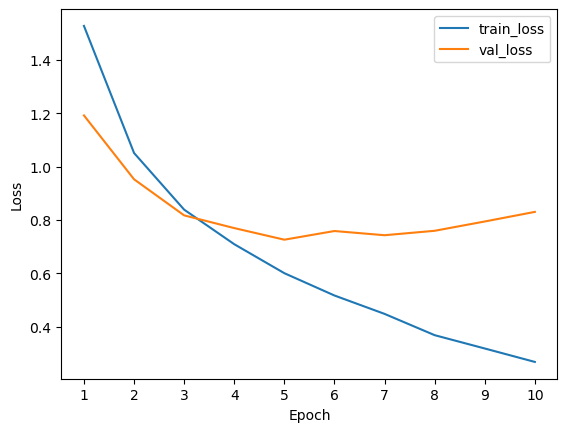

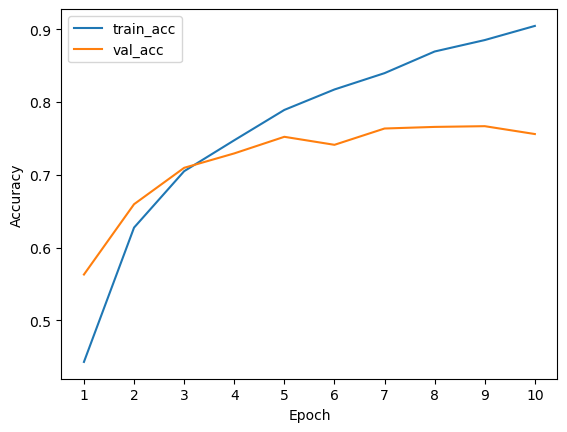

In [69]:
# Plotting loss and accuracy
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_hist) + 1)

plt.figure()
plt.plot(epochs, train_loss_hist, label="train_loss")
plt.plot(epochs, val_loss_hist, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_acc_hist, label="train_acc")
plt.plot(epochs, val_acc_hist, label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()
plt.show()

(10, 10)


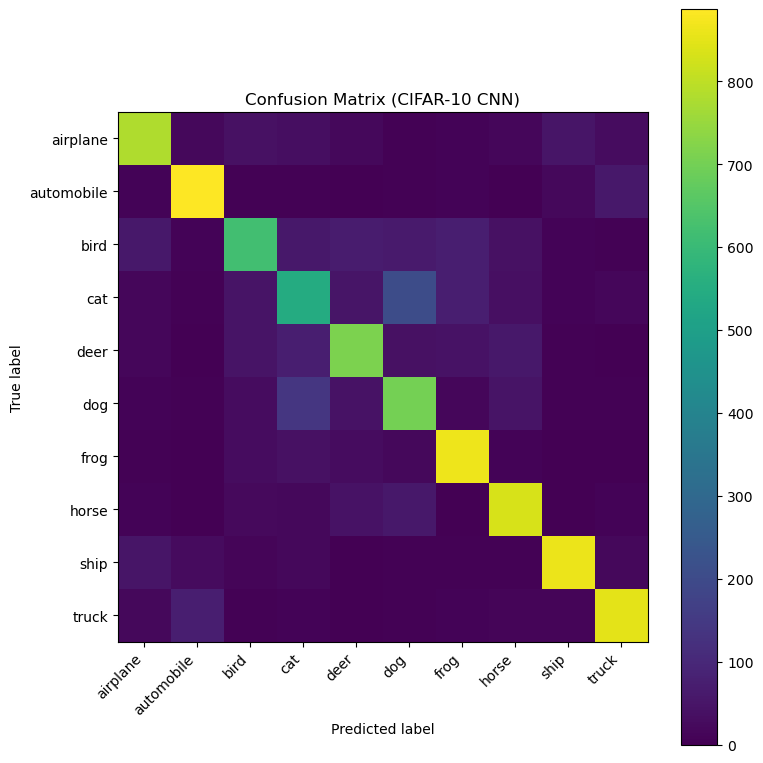

In [70]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape) 

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (CIFAR-10 CNN)")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.tight_layout()
plt.show()